## Amazon Polarity Review 

##### The purpose of this piece of work is to compare Bag of Words model with embedding models on a relatively small dataset (60,000 records)

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Layer
from keras.layers import Dense, Input, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D
import tensorflow as tf
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import fasttext
import warnings
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
warnings.filterwarnings('ignore')

#### Train the word representation for fast text using the first 1 billion wikipedia text

In [3]:
model = fasttext.train_unsupervised('fastText-0.9.2/data/enwik9-text', dim=300)
model.save_model("enwik9-model-300d.bin")

In [4]:
validation_accuracies = dict()
models = dict()
auc_scores = dict()

In [5]:
def plot_graph(history):
    val_acc, train_acc, val_loss, train_loss = history['val_accuracy'],history['accuracy'], \
    history['val_loss'], history['loss']
    plt.clf()
    epochs = range(1, len(train_acc) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].plot(epochs, train_acc, color='red', label='Training Accuracy')
    ax[0].plot(epochs, val_acc, color='blue', label='Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and validation Accuracy')
    ax[0].legend()
    ax[1].plot(epochs, train_loss, color='red', label='Training loss')
    ax[1].plot(epochs, val_loss, color='blue', label='Validation loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Training and validation Loss')
    ax[1].legend()
    plt.show()

In [6]:
def prepare_dataframe():
    train_df = pd.read_csv('amazon_review_polarity_csv/train.csv', 
                           nrows=45000, header=None) 
    test_df = pd.read_csv('amazon_review_polarity_csv/test.csv', 
                          nrows=15000, header=None)
    train_df[0] = train_df[0].replace({1:0, 2:1})
    test_df[0] = test_df[0].replace({1:0, 2:1})
    ## Concatenate title and review
    for i in train_df.index:
        series = train_df.iloc[i]
        train_df.at[i, 3] = f'{series[1]}. {series[2]}'
    for i in test_df.index:
        series = test_df.iloc[i]
        test_df.at[i, 3] = f'{series[1]}. {series[2]}'
    return train_df, test_df

In [7]:
def load_doc(filename):
    with(open(filename, 'r')) as file:
        content = file.read()
    return content

def convert_sentence_to_word_list(sentence):
    words = sentence.split()
    words = [word for word in words]
    return words

def get_vocab_and_save_to_file():
    vocab_counter = Counter()
    words = []
    for val in x_train:
        words = convert_sentence_to_word_list(val)
        vocab_counter.update(words)
    min_count = 10
    tokens = [k for k,c in vocab_counter.items() if c >= min_count]
    print(len(tokens))
    filename = 'vocabulary.txt'
    with(open(filename, 'w')) as file:
        data = '\n'.join(tokens)
        file.write(data)
    return vocab_counter

In [8]:
def get_tokens_from_sentence(sentence, vocab):
    sentence = convert_sentence_to_word_list(sentence)
    tokens = [word for word in sentence if word in vocab]
    return ' '.join(tokens)

def load_vocabulary(filename):
    vocab = load_doc(filename)
    vocab = vocab.split()
    vocab = set(vocab)
    return vocab

In [9]:
def get_tokenizer(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    return tokenizer

def get_test_and_train_data_from_vocabulary(vocab):
    train_data = []
    for val in x_train:
        train_data.append(get_tokens_from_sentence(val, vocab))
    test_data = []
    for val in x_test:
        test_data.append(get_tokens_from_sentence(val, vocab))
    return train_data, test_data

In [10]:
def fit_with_bag_of_word_model(optimizer, tokenized_x_train, y_train, 
                               tokenized_x_test, y_test, epoch_size):
    model = Sequential()
    model.add(Dense(4, input_shape=(tokenized_x_train.shape[1],), activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = model.fit(x=np.array(tokenized_x_train), y=np.array(y_train),
                        validation_data=(np.array(tokenized_x_test),np.array(y_test)),
                        epochs=epoch_size, batch_size=16, verbose=0,)
    plot_graph(history.history)
    val_accuracy = model.evaluate(np.array(tokenized_x_test),np.array(y_test))[1]*100
    validation_accuracies['Bag of Words Model'] = val_accuracy
    models['BOW'] = model
    print(f'Validation accuracy => {val_accuracy}%')
    return history

In [11]:
train_df, test_df = prepare_dataframe()

In [12]:
x_train, y_train, x_test, y_test = train_df[3], train_df[0], test_df[3], test_df[0]

In [13]:
vocab_counter = get_vocab_and_save_to_file()

18398


In [14]:
vocab = load_vocabulary('vocabulary.txt')

In [15]:
train_data, test_data = get_test_and_train_data_from_vocabulary(vocab)
tokenizer = get_tokenizer(train_data)

### Bag of Words Model

In [16]:
tokenized_x_train = tokenizer.texts_to_matrix(train_data, mode='freq')
tokenized_x_test = tokenizer.texts_to_matrix(test_data, mode='freq')

In [17]:
num_words = tokenized_x_train.shape[1]

In [18]:
print("Number of words in vocabulary is ", num_words)

Number of words in vocabulary is  10320


2022-05-01 14:51:32.029135: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 432x288 with 0 Axes>

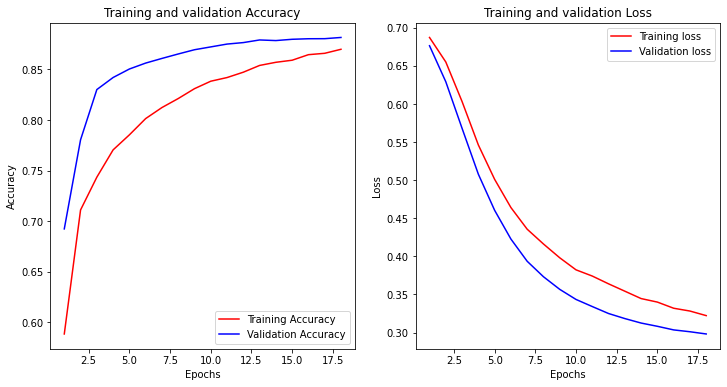

469/469 [==============================] - 2s 4ms/step - loss: 0.2982 - accuracy: 0.8817
Validation accuracy => 88.16666603088379%
CPU times: user 3min 53s, sys: 42.7 s, total: 4min 35s
Wall time: 3min 19s


In [19]:
adam_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
%time fit_with_bag_of_word_model(adam_optimizer,tokenized_x_train, y_train, tokenized_x_test, y_test, 18) 

### Embedding with Glove

https://keras.io/examples/nlp/pretrained_word_embeddings/

In [20]:
def load_embedding_index_from_glove():
    embeddings_index = dict()
    with (open('glove.6B/glove.6B.300d.txt', mode='rt', encoding='utf-8')) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [21]:
def get_embedding_matrix_from_glove_embedding(tokenizer, embeddings_index, tokens):
    num_tokens = len(tokens) + 2
    embedding_dim = 300
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix

In [22]:
def fit_with_glove_embedding(embedding_layer, tokens, train_data, test_data, optimizer, epoch_size):
    vectorize_layer = keras.layers.TextVectorization(output_mode='int', max_tokens = len(tokens)+2,
                                                     pad_to_max_tokens=True, vocabulary=tokens)
    vect_train = vectorize_layer(np.array([[s] for s in train_data])).numpy()
    vect_test = vectorize_layer(np.array([[s] for s in test_data])).numpy()
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Conv1D(32, 3, activation="relu")(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.3)(x)
    preds = Dense(1, activation="sigmoid")(x)
    model = keras.Model(int_sequences_input, preds)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, 
                  metrics=["accuracy"])
    history = model.fit(vect_train, np.array(y_train), batch_size=32, epochs=epoch_size,
              validation_data=(vect_test, np.array(y_test)), verbose=0)
    plot_graph(history.history)
    val_accuracy = model.evaluate(vect_test,np.array(y_test))[1]*100
    validation_accuracies['Glove Embedding'] = val_accuracy
    models['Glove'] = model
    print(f'Validation accuracy => {val_accuracy}%')
    return history

In [23]:
embeddings_index = load_embedding_index_from_glove()

Loaded 400000 word vectors.


In [24]:
tokens = [k for k,c in vocab_counter.items() if c >= 10]
embedding_matrix = get_embedding_matrix_from_glove_embedding(tokenizer, embeddings_index, tokens)
embedding_layer = Embedding(len(tokens)+2, 300,
                                 embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                 trainable=False,)
nadam_optimizer = keras.optimizers.Nadam(learning_rate=0.0001)

Converted 9979 words (340 misses)


<Figure size 432x288 with 0 Axes>

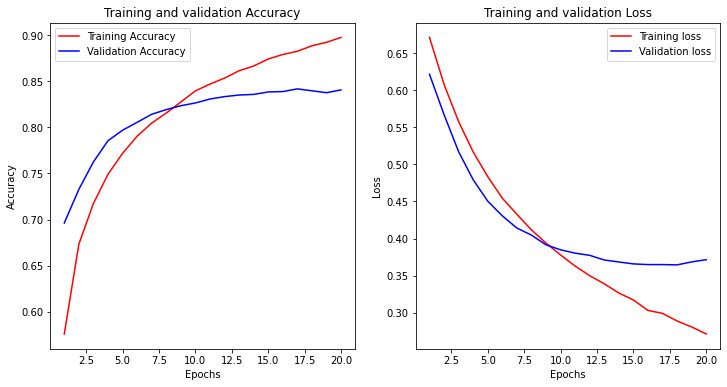

469/469 [==============================] - 6s 13ms/step - loss: 0.3714 - accuracy: 0.8405
Validation accuracy => 84.05333161354065%


In [25]:
history = fit_with_glove_embedding(embedding_layer, tokens, train_data,
                                   test_data, nadam_optimizer, 20)

### Embedding with word2vec

In [26]:
filename = 'google-wordvec/GoogleNews-vectors-negative300.bin'
gvector_index = KeyedVectors.load_word2vec_format(filename, binary=True)

In [27]:
def get_embedding_matrix_from_word2vec_embedding(tokenizer, gvector_index, tokens):
    num_tokens = len(tokens) + 2
    gembedding_dim = 300
    hits = 0
    misses = 0
    # Prepare embedding matrix
    gembedding_matrix = np.zeros((num_tokens, gembedding_dim))
    for word, i in tokenizer.word_index.items():
        gembedding_vector = None
        try:
            gembedding_vector = gvector_index.get_vector(word)
        except:
            pass
        if gembedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            gembedding_matrix[i] = gembedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return gembedding_matrix

In [28]:
def fit_with_word2vec_embedding(embedding_layer, tokens, train_data, test_data, optimizer, epoch_size):
    vectorize_layer = keras.layers.TextVectorization(output_mode='int', max_tokens = len(tokens)+2, 
                                                 pad_to_max_tokens=True, vocabulary=tokens)
    gvect_train = vectorize_layer(np.array([[s] for s in train_data])).numpy()
    gvect_test = vectorize_layer(np.array([[s] for s in test_data])).numpy()
    gint_sequences_input = keras.Input(shape=(None,), dtype="int64")
    gembedded_sequences = embedding_layer(gint_sequences_input)
    x = Conv1D(32, 3, activation="relu")(gembedded_sequences)
    x = MaxPooling1D(3)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.5)(x)
    preds = Dense(1, activation="sigmoid")(x)
    gmodel = keras.Model(gint_sequences_input, preds)
    gmodel.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, 
                   metrics=["accuracy"])
    history = gmodel.fit(gvect_train, np.array(y_train), batch_size=32, epochs=epoch_size, 
               validation_data=(gvect_test, np.array(y_test)), verbose=0)
    plot_graph(history.history)
    val_accuracy = gmodel.evaluate(gvect_test,np.array(y_test))[1]*100
    validation_accuracies['Word2Vec Embedding'] = val_accuracy
    models['Word2Vec'] = gmodel
    opt_name = optimizer.get_config()['name']
    print(f'Validation accuracy for optimizer {opt_name} => {val_accuracy}%')
    return history

In [29]:
gvector_index.init_sims(replace=True)
gembedding_matrix = get_embedding_matrix_from_word2vec_embedding(tokenizer, gvector_index, tokens)
gembedding_layer = Embedding(len(tokens)+2, 300, 
                             embeddings_initializer=keras.initializers.Constant(gembedding_matrix),
                                  trainable=False,)
nadam_optimizer = keras.optimizers.Nadam(learning_rate=0.0001)

Converted 9695 words (624 misses)


<Figure size 432x288 with 0 Axes>

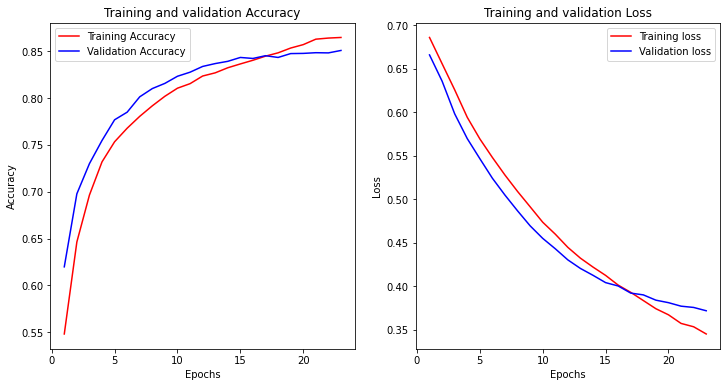

469/469 [==============================] - 10s 21ms/step - loss: 0.3716 - accuracy: 0.8507
Validation accuracy for optimizer Nadam => 85.07333397865295%


In [30]:
history = fit_with_word2vec_embedding(gembedding_layer, tokens, train_data, 
                                      test_data, nadam_optimizer, 23)

### FastText Word representation

##### Load my trained vector representation

In [31]:
fast_text_embeddings_index = fasttext.load_model('enwik9-model-300d.bin')

In [32]:
def get_embedding_matrix_from_fast_text(tokenizer, embeddings_index, tokens):
    num_tokens = len(tokens) + 2
    embedding_dim = 300
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get_word_vector(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix

In [33]:
def fit_with_fast_text_embedding(embedding_layer, tokens, train_data, test_data, optimizer, epoch_size):
    vectorize_layer = keras.layers.TextVectorization(output_mode='int', max_tokens = len(tokens)+2,
                                                     pad_to_max_tokens=True, vocabulary=tokens)
    vect_train = vectorize_layer(np.array([[s] for s in train_data])).numpy()
    vect_test = vectorize_layer(np.array([[s] for s in test_data])).numpy()
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Conv1D(32, 3, activation="relu")(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.3)(x)
    preds = Dense(1, activation="sigmoid")(x)
    model = keras.Model(int_sequences_input, preds)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, 
                  metrics=["accuracy"])
    history = model.fit(vect_train, np.array(y_train), batch_size=32, epochs=epoch_size,
              validation_data=(vect_test, np.array(y_test)), verbose=0)
    plot_graph(history.history)
    val_accuracy = model.evaluate(vect_test,np.array(y_test))[1]*100
    validation_accuracies['FastText Embedding'] = val_accuracy
    models['FastText'] = model
    print(f'Validation accuracy => {val_accuracy}%')
    return history

In [34]:
embedding_matrix = get_embedding_matrix_from_fast_text(tokenizer,
                                                            fast_text_embeddings_index, tokens)
embedding_layer = Embedding(len(tokens)+2, 300,
                                 embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                 trainable=False,)

Converted 10319 words (0 misses)


<Figure size 432x288 with 0 Axes>

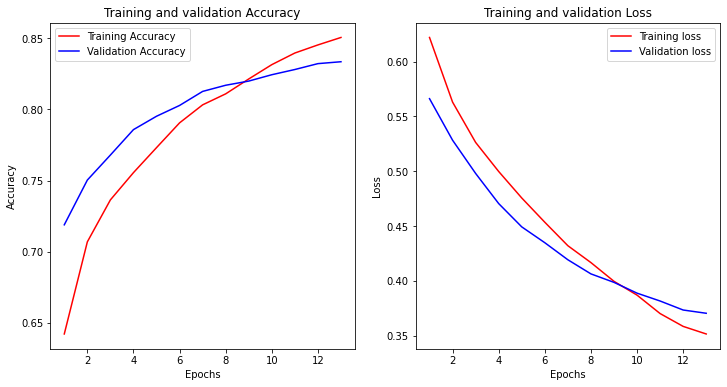

469/469 [==============================] - 9s 18ms/step - loss: 0.3703 - accuracy: 0.8335
Validation accuracy => 83.35333466529846%


In [35]:
history = fit_with_fast_text_embedding(embedding_layer, tokens, train_data, 
                                      test_data, nadam_optimizer, 13)

In [36]:
def calculate_roc_auc_score_and_visualise():
    ## BOW
    bow_prob = models['BOW'].predict(tokenized_x_test).tolist()
    bow_fpr, bow_tpr,bow_threshold = roc_curve(y_test, bow_prob)
    bow_auc_score = roc_auc_score(y_test, bow_prob)
    ## Vectorize test data for embeddings
    vectorize_layer = keras.layers.TextVectorization(output_mode='int', max_tokens = len(tokens)+2,
                                                     pad_to_max_tokens=True, vocabulary=tokens)
    vect_test = vectorize_layer(np.array([[s] for s in test_data])).numpy()
    ## Glove
    glove_prob = models['Glove'].predict(vect_test).tolist()
    glove_fpr, glove_tpr,glove_threshold = roc_curve(y_test, glove_prob)
    glove_auc_score = roc_auc_score(y_test, glove_prob)
    ## Word2Vec
    word2vec_prob = models['Word2Vec'].predict(vect_test).tolist()
    word2vec_fpr, word2vec_tpr,word2vec_threshold = roc_curve(y_test, word2vec_prob)
    word2vec_auc_score = roc_auc_score(y_test, word2vec_prob)
    ## FastText
    fasttext_prob = models['FastText'].predict(vect_test).tolist()
    fasttext_fpr, fasttext_tpr,fasttext_threshold = roc_curve(y_test, fasttext_prob)
    fasttext_auc_score = roc_auc_score(y_test, fasttext_prob)
    ## Print scores
    auc_scores['Bag of Words Model'] = bow_auc_score
    auc_scores['Glove Embedding'] = glove_auc_score
    auc_scores['Word2Vec Embedding'] = word2vec_auc_score
    auc_scores['FastText Embedding'] = fasttext_auc_score
    print(f"ROC-AUC score for BOW is ", bow_auc_score)
    print(f"ROC-AUC score for Glove is ", glove_auc_score)
    print(f"ROC-AUC score for Word2vec is ", word2vec_auc_score)
    print(f"ROC-AUC score for FastText is ", fasttext_auc_score)
    #### Plot ROC-AUC graph
    plt.figure(figsize=(8,6))
    plt.plot(bow_fpr, bow_tpr,color='green', label='BOW Model')
    plt.plot(glove_fpr, glove_tpr,color='purple', label='Glove Model')
    plt.plot(word2vec_fpr, word2vec_tpr,color='orange', label='Word2vec Model')
    plt.plot(fasttext_fpr, fasttext_tpr,color='blue', label='FastText Model')
    plt.title('ROC-AUC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend()
    plt.show();

#### ROC-AUC GRAPH

ROC-AUC score for BOW is  0.9486245298176333
ROC-AUC score for Glove is  0.919626609867669
ROC-AUC score for Word2vec is  0.9238266291747097
ROC-AUC score for FastText is  0.9156757968390756


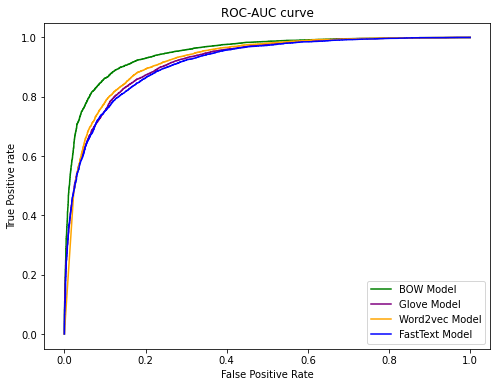

In [37]:
calculate_roc_auc_score_and_visualise()

### Validation summary

In [38]:
pd.DataFrame(pd.Series(validation_accuracies), columns=['Validation Accuracy'])

,Validation Accuracy
Bag of Words Model,88.166666
Glove Embedding,84.053332
Word2Vec Embedding,85.073334
FastText Embedding,83.353335


#### AUC summary

In [39]:
pd.DataFrame(pd.Series(auc_scores), columns=['AUC Score'])

,AUC Score
Bag of Words Model,0.948625
Glove Embedding,0.919627
Word2Vec Embedding,0.923827
FastText Embedding,0.915676
